#### Imports

In [82]:
import pandas
import numpy as np
import re
import sqlite3
import logging
import multiprocessing
import gensim
import imblearn
import pickle

import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from keras.models import load_model
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input
from keras.layers.embeddings import Embedding

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint

## Common
#### Paths, names and common constants

In [83]:
POSITIVE_MARK = 1
NEGATIVE_MARK = -1

In [84]:
# main paths
RESOURCES = 'resources/'

DATA_PATH = RESOURCES + 'data/'
MODEL_PATH = RESOURCES + 'models/'
TOKENIZERS_PATH = RESOURCES + 'tokenizers/'

# data paths and names
TWITTER_DATABASE = 'E:/PROGRAM/mysql2sqlite/twitter_database.db'
REVIEWS_PATH = DATA_PATH + 'reviews/'

TWITTER_POSITIVE_NAME = 'twitter_positive.csv'
TWITTER_NEGATIVE_NAME = 'twitter_negative.csv'
TWITTER_COMMON_NAME = 'tweets.txt'
REVIEW_COMMON_NAME = 'reviews.txt'

# cnn
TWITTER_CNN_PATH = MODEL_PATH + 'twitter_cnn/'
REVIEWS_CNN_PATH = MODEL_PATH + 'reviews_cnn/'

# w2v
TWITTER_MODEL_NAME = 'twitter_model.w2v'
REVIEW_MODEL_NAME = 'reviews_model.w2v'

# Review name template: 'review_' + <review_number> + '.txt'
REVIEW_PREFIX = 'review_'
REVIEW_SUFFIX = '.txt'

# models
TWITTER_MODEL = MODEL_PATH + 'twitter_model.h5'
REVIEWS_MODEL = MODEL_PATH + 'reviews_model.h5'
COMMON_MODEL = MODEL_PATH + 'common_model.pickle'

# tokenizers
TWITTER_TOKENIZER = TOKENIZERS_PATH + 'twitter_tokenizer.pickle'
REVIEWS_TOKENIZER = TOKENIZERS_PATH + 'reviews_tokenizer.pickle'
COMMON_TOKENIZER = TOKENIZERS_PATH + 'common_tokenizer.pickle'

#### Metrics

In [48]:
def precision(y_true, y_pred):
    # Precision metric.
    # Only computes a batch-wise average of precision.
    # Computes the precision, a metric for multi-label classification of
    # how many selected items are relevant.
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    # Recall metric.
    # Only computes a batch-wise average of recall.
    # Computes the recall, a metric for multi-label classification of
    # how many relevant items are selected.
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

#### Plotter

In [49]:
def plot_histogram(values, bins, max_x, max_y):
    plt.style.use('ggplot')
    plt.figure(figsize = (16, 9))

    n, bins, patches = plt.hist(
        x = values,
        bins = bins,
        density = True
    )

    plt.xlabel('Количество слов в сообщении')
    plt.axis([0, max_x, 0, max_y])
    plt.grid(True)
    plt.show()

def plot_history(history):
    plt.style.use('ggplot')

    def plot_metrix(ax, x1, x2, title):
        ax.plot(range(1, len(x1) + 1), x1, label='train')
        ax.plot(range(1, len(x2) + 1), x2, label='val')
        ax.set_ylabel(title)
        ax.set_xlabel('Epoch')
        ax.legend()
        ax.margins(0)
    
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    plt.show()

## Twitter
#### Twitter constants

In [51]:
# table column names
twitter_db_titles = ['id', 'date', 'name', 'text',
                     'type', 'reply', 'retwit', 'favorite',
                     'stcount', 'followers', 'friends', 'listcount']

twitter_usecols = ['text', 'type']

# maximum number of words in one twitter message
TWITTER_MAX_WORDS_COUNT = 26
# number of words in the dictionary of twitter messages
TWITTER_DICT_SIZE = 100000

#### Read data

In [52]:
twitter_data_positive = pandas.read_csv(
    DATA_PATH + TWITTER_POSITIVE_NAME,
    sep = ';',
    error_bad_lines = False,
    names = twitter_db_titles,
    usecols = twitter_usecols
)

twitter_data_negative = pandas.read_csv(
    DATA_PATH + TWITTER_NEGATIVE_NAME,
    sep = ';',
    error_bad_lines = False,
    names = twitter_db_titles,
    usecols = twitter_usecols
)

#### Print data head

In [53]:
twitter_data_positive.head()

text  type
0  @first_timee хоть я и школота, но поверь, у на...     1
1  Да, все-таки он немного похож на него. Но мой ...     1
2  RT @KatiaCheh: Ну ты идиотка) я испугалась за ...     1
3  RT @digger2912: "Кто то в углу сидит и погибае...     1
4  @irina_dyshkant Вот что значит страшилка :D\nН...     1

In [54]:
twitter_data_negative.head()

text  type
0  на работе был полный пиддес :| и так каждое за...    -1
1  Коллеги сидят рубятся в Urban terror, а я из-з...    -1
2  @elina_4post как говорят обещаного три года жд...    -1
3  Желаю хорошего полёта и удачной посадки,я буду...    -1
4  Обновил за каким-то лешим surf, теперь не рабо...    -1

#### Data preparation

In [55]:
# balancing samples of positive and negative messages
twitter_sample_size = min(
    twitter_data_positive.shape[0],
    twitter_data_negative.shape[0]
)
print('Tweets Positive data: ', twitter_data_positive.shape[0])
print('Tweets Negative data: ', twitter_data_negative.shape[0])
print('Tweets Sample data: ', twitter_sample_size)

Tweets Positive data:  114911
Tweets Negative data:  111923
Tweets Sample data:  111923


In [56]:
twitter_text_raw_data = np.concatenate(
    (twitter_data_positive['text'].values[:twitter_sample_size], 
     twitter_data_negative['text'].values[:twitter_sample_size]), 
    axis = 0
)

In [57]:
def preprocess_tweets(tweet_text):
    tweet_text = tweet_text.lower()
    tweet_text = tweet_text.replace('ё', 'е')
    tweet_text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet_text)
    tweet_text = re.sub('@[^\s]+', 'USER', tweet_text)
    tweet_text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', tweet_text)
    tweet_text = re.sub(' +', ' ', tweet_text)
    return tweet_text.strip()

In [58]:
twitter_processed_data = [preprocess_tweets(tweet_text) for tweet_text in twitter_text_raw_data]
twitter_labels = [1] * twitter_sample_size + [0] * twitter_sample_size

#### Break the data into training, test and validation
* train 0.6
* test 0.2
* val 0.2

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    twitter_processed_data,
    twitter_labels,
    test_size = 0.2,
    random_state = 1
)

print('train:', len(X_train) * 0.75, 'is', len(X_train) * 0.75 / len(twitter_processed_data))
print('test:', len(X_test), 'is', len(X_test) / len(twitter_processed_data))
print('val:', len(X_train) * 0.25, 'is', len(X_train) * 0.25 / len(twitter_processed_data))

train: 134307.0 is 0.5999973195857866
test: 44770 is 0.2000035738856178
val: 44769.0 is 0.19999910652859557


#### Print all tweets in file

In [19]:
# Open SQLite Database
conn = sqlite3.connect(TWITTER_DATABASE)
twitter_db_cursor = conn.cursor()

In [21]:
with open(DATA_PATH + TWITTER_COMMON_NAME, 'w', encoding = 'utf-8') as output:
    # Read Tweet Texts
    for row in twitter_db_cursor.execute('SELECT ttext FROM sentiment'):
        if row[0]:
            tweet = preprocess_tweets(row[0])
            # Write pre-processed tweets to file
            print(tweet, file = output)

#### Visualization for Tweets

In [60]:
tweets = open(DATA_PATH + TWITTER_COMMON_NAME, encoding = 'utf-8').read().splitlines()
%matplotlib inline
twitter_preprocessed_data = pandas.Series(tweets).apply(lambda x: len(x.split()))

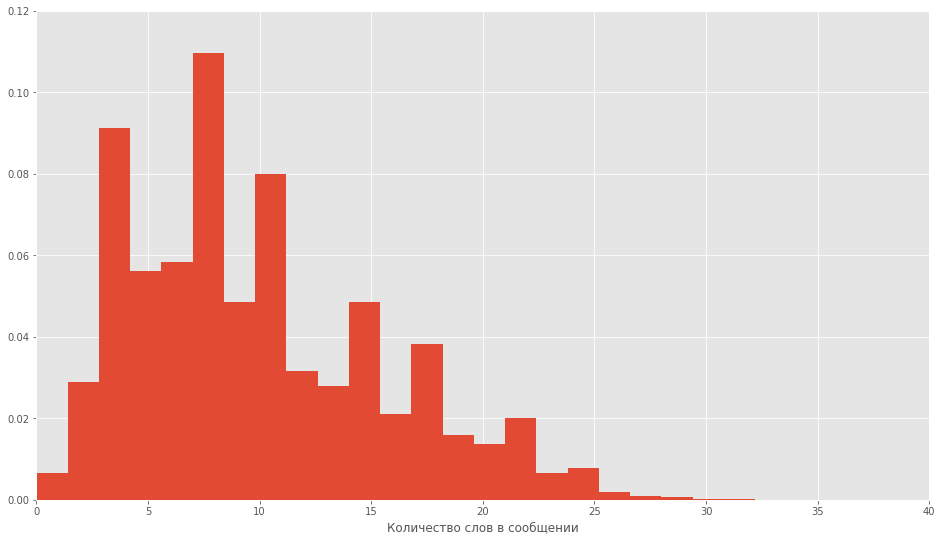

In [61]:
plot_histogram(
    twitter_preprocessed_data.values,
    bins = 50,
    max_x = 40,
    max_y = 0.12
)

#### Select the optimal length

In [62]:
for i in range(20, 35, 1):
    twitter_preprocessed_data > i
    percent = (twitter_preprocessed_data > i).sum() / twitter_preprocessed_data.shape[0]
    print("%0.5f for sentence_length = %r" % (1 - percent, i))

0.94599 for sentence_length = 20
0.96172 for sentence_length = 21
0.97419 for sentence_length = 22
0.98353 for sentence_length = 23
0.99021 for sentence_length = 24
0.99457 for sentence_length = 25
0.99712 for sentence_length = 26
0.99849 for sentence_length = 27
0.99924 for sentence_length = 28
0.99959 for sentence_length = 29
0.99975 for sentence_length = 30
0.99984 for sentence_length = 31
0.99988 for sentence_length = 32
0.99990 for sentence_length = 33
0.99992 for sentence_length = 34


#### Train Word2Vec model

In [63]:
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', level = logging.INFO)

twitter_data = LineSentence(DATA_PATH + TWITTER_COMMON_NAME)

twitter_model = Word2Vec(
    twitter_data,
    size = 200,
    window = 5,
    min_count = 3,
    workers = multiprocessing.cpu_count()
)

twitter_model.save(MODEL_PATH + TWITTER_MODEL_NAME)

2020-06-10 21:58:39,280 : INFO : collecting all words and their counts
2020-06-10 21:58:39,283 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-06-10 21:58:39,354 : INFO : PROGRESS: at sentence #10000, processed 98345 words, keeping 24248 word types
2020-06-10 21:58:39,421 : INFO : PROGRESS: at sentence #20000, processed 194782 words, keeping 38847 word types
2020-06-10 21:58:39,495 : INFO : PROGRESS: at sentence #30000, processed 290743 words, keeping 50531 word types
2020-06-10 21:58:39,562 : INFO : PROGRESS: at sentence #40000, processed 386269 words, keeping 60653 word types
2020-06-10 21:58:39,633 : INFO : PROGRESS: at sentence #50000, processed 482755 words, keeping 69689 word types
2020-06-10 21:58:39,703 : INFO : PROGRESS: at sentence #60000, processed 578104 words, keeping 78235 word types
2020-06-10 21:58:39,766 : INFO : PROGRESS: at sentence #70000, processed 672686 words, keeping 85840 word types
2020-06-10 21:58:39,829 : INFO : PROGRESS: at s

2020-06-10 21:58:44,170 : INFO : PROGRESS: at sentence #720000, processed 6856226 words, keeping 329362 word types
2020-06-10 21:58:44,238 : INFO : PROGRESS: at sentence #730000, processed 6953689 words, keeping 331913 word types
2020-06-10 21:58:44,309 : INFO : PROGRESS: at sentence #740000, processed 7054203 words, keeping 334539 word types
2020-06-10 21:58:44,373 : INFO : PROGRESS: at sentence #750000, processed 7153523 words, keeping 336844 word types
2020-06-10 21:58:44,444 : INFO : PROGRESS: at sentence #760000, processed 7253230 words, keeping 339124 word types
2020-06-10 21:58:44,521 : INFO : PROGRESS: at sentence #770000, processed 7352424 words, keeping 341418 word types
2020-06-10 21:58:44,600 : INFO : PROGRESS: at sentence #780000, processed 7450987 words, keeping 343877 word types
2020-06-10 21:58:44,665 : INFO : PROGRESS: at sentence #790000, processed 7545233 words, keeping 346595 word types
2020-06-10 21:58:44,723 : INFO : PROGRESS: at sentence #800000, processed 763865

2020-06-10 21:58:48,636 : INFO : PROGRESS: at sentence #1430000, processed 13698594 words, keeping 494012 word types
2020-06-10 21:58:48,699 : INFO : PROGRESS: at sentence #1440000, processed 13799436 words, keeping 496301 word types
2020-06-10 21:58:48,766 : INFO : PROGRESS: at sentence #1450000, processed 13898908 words, keeping 498556 word types
2020-06-10 21:58:48,830 : INFO : PROGRESS: at sentence #1460000, processed 13996483 words, keeping 500687 word types
2020-06-10 21:58:48,895 : INFO : PROGRESS: at sentence #1470000, processed 14094360 words, keeping 502819 word types
2020-06-10 21:58:48,962 : INFO : PROGRESS: at sentence #1480000, processed 14192679 words, keeping 504855 word types
2020-06-10 21:58:49,027 : INFO : PROGRESS: at sentence #1490000, processed 14291910 words, keeping 507157 word types
2020-06-10 21:58:49,092 : INFO : PROGRESS: at sentence #1500000, processed 14391159 words, keeping 509297 word types
2020-06-10 21:58:49,155 : INFO : PROGRESS: at sentence #1510000,

2020-06-10 21:58:53,169 : INFO : PROGRESS: at sentence #2140000, processed 20623466 words, keeping 625917 word types
2020-06-10 21:58:53,228 : INFO : PROGRESS: at sentence #2150000, processed 20722248 words, keeping 627462 word types
2020-06-10 21:58:53,287 : INFO : PROGRESS: at sentence #2160000, processed 20819863 words, keeping 629122 word types
2020-06-10 21:58:53,361 : INFO : PROGRESS: at sentence #2170000, processed 20917554 words, keeping 630708 word types
2020-06-10 21:58:53,423 : INFO : PROGRESS: at sentence #2180000, processed 21015641 words, keeping 632393 word types
2020-06-10 21:58:53,483 : INFO : PROGRESS: at sentence #2190000, processed 21113827 words, keeping 634124 word types
2020-06-10 21:58:53,549 : INFO : PROGRESS: at sentence #2200000, processed 21212464 words, keeping 635844 word types
2020-06-10 21:58:53,609 : INFO : PROGRESS: at sentence #2210000, processed 21310897 words, keeping 637585 word types
2020-06-10 21:58:53,673 : INFO : PROGRESS: at sentence #2220000,

2020-06-10 21:58:59,095 : INFO : PROGRESS: at sentence #2850000, processed 27587700 words, keeping 742350 word types
2020-06-10 21:58:59,177 : INFO : PROGRESS: at sentence #2860000, processed 27686628 words, keeping 744033 word types
2020-06-10 21:58:59,250 : INFO : PROGRESS: at sentence #2870000, processed 27788789 words, keeping 745708 word types
2020-06-10 21:58:59,328 : INFO : PROGRESS: at sentence #2880000, processed 27885614 words, keeping 747258 word types
2020-06-10 21:58:59,409 : INFO : PROGRESS: at sentence #2890000, processed 27979645 words, keeping 748829 word types
2020-06-10 21:58:59,496 : INFO : PROGRESS: at sentence #2900000, processed 28075614 words, keeping 750449 word types
2020-06-10 21:58:59,588 : INFO : PROGRESS: at sentence #2910000, processed 28172950 words, keeping 752004 word types
2020-06-10 21:58:59,664 : INFO : PROGRESS: at sentence #2920000, processed 28270410 words, keeping 753472 word types
2020-06-10 21:58:59,762 : INFO : PROGRESS: at sentence #2930000,

2020-06-10 21:59:05,528 : INFO : PROGRESS: at sentence #3560000, processed 34438798 words, keeping 843762 word types
2020-06-10 21:59:05,590 : INFO : PROGRESS: at sentence #3570000, processed 34531015 words, keeping 844977 word types
2020-06-10 21:59:05,678 : INFO : PROGRESS: at sentence #3580000, processed 34624100 words, keeping 846165 word types
2020-06-10 21:59:05,762 : INFO : PROGRESS: at sentence #3590000, processed 34719148 words, keeping 847374 word types
2020-06-10 21:59:05,849 : INFO : PROGRESS: at sentence #3600000, processed 34819053 words, keeping 848814 word types
2020-06-10 21:59:05,931 : INFO : PROGRESS: at sentence #3610000, processed 34918864 words, keeping 850243 word types
2020-06-10 21:59:06,030 : INFO : PROGRESS: at sentence #3620000, processed 35018239 words, keeping 851702 word types
2020-06-10 21:59:06,109 : INFO : PROGRESS: at sentence #3630000, processed 35117362 words, keeping 853081 word types
2020-06-10 21:59:06,182 : INFO : PROGRESS: at sentence #3640000,

2020-06-10 21:59:12,786 : INFO : PROGRESS: at sentence #4270000, processed 41464980 words, keeping 938539 word types
2020-06-10 21:59:12,907 : INFO : PROGRESS: at sentence #4280000, processed 41568173 words, keeping 939803 word types
2020-06-10 21:59:13,022 : INFO : PROGRESS: at sentence #4290000, processed 41671892 words, keeping 941077 word types
2020-06-10 21:59:13,179 : INFO : PROGRESS: at sentence #4300000, processed 41775515 words, keeping 942401 word types
2020-06-10 21:59:13,309 : INFO : PROGRESS: at sentence #4310000, processed 41878294 words, keeping 943781 word types
2020-06-10 21:59:13,451 : INFO : PROGRESS: at sentence #4320000, processed 41981059 words, keeping 945058 word types
2020-06-10 21:59:13,584 : INFO : PROGRESS: at sentence #4330000, processed 42081929 words, keeping 946331 word types
2020-06-10 21:59:13,705 : INFO : PROGRESS: at sentence #4340000, processed 42185413 words, keeping 947628 word types
2020-06-10 21:59:13,843 : INFO : PROGRESS: at sentence #4350000,

2020-06-10 21:59:19,722 : INFO : PROGRESS: at sentence #4970000, processed 48525276 words, keeping 1025892 word types
2020-06-10 21:59:19,790 : INFO : PROGRESS: at sentence #4980000, processed 48623603 words, keeping 1027015 word types
2020-06-10 21:59:19,860 : INFO : PROGRESS: at sentence #4990000, processed 48721784 words, keeping 1028147 word types
2020-06-10 21:59:19,924 : INFO : PROGRESS: at sentence #5000000, processed 48820650 words, keeping 1029291 word types
2020-06-10 21:59:19,990 : INFO : PROGRESS: at sentence #5010000, processed 48919694 words, keeping 1030453 word types
2020-06-10 21:59:20,056 : INFO : PROGRESS: at sentence #5020000, processed 49015912 words, keeping 1031664 word types
2020-06-10 21:59:20,152 : INFO : PROGRESS: at sentence #5030000, processed 49114805 words, keeping 1032739 word types
2020-06-10 21:59:20,256 : INFO : PROGRESS: at sentence #5040000, processed 49214888 words, keeping 1033813 word types
2020-06-10 21:59:20,326 : INFO : PROGRESS: at sentence #

2020-06-10 21:59:24,832 : INFO : PROGRESS: at sentence #5670000, processed 55510788 words, keeping 1106006 word types
2020-06-10 21:59:24,901 : INFO : PROGRESS: at sentence #5680000, processed 55607005 words, keeping 1107034 word types
2020-06-10 21:59:24,979 : INFO : PROGRESS: at sentence #5690000, processed 55701085 words, keeping 1108151 word types
2020-06-10 21:59:25,046 : INFO : PROGRESS: at sentence #5700000, processed 55796372 words, keeping 1109193 word types
2020-06-10 21:59:25,113 : INFO : PROGRESS: at sentence #5710000, processed 55894523 words, keeping 1110264 word types
2020-06-10 21:59:25,178 : INFO : PROGRESS: at sentence #5720000, processed 55991793 words, keeping 1111332 word types
2020-06-10 21:59:25,242 : INFO : PROGRESS: at sentence #5730000, processed 56089952 words, keeping 1112456 word types
2020-06-10 21:59:25,306 : INFO : PROGRESS: at sentence #5740000, processed 56186683 words, keeping 1113552 word types
2020-06-10 21:59:25,375 : INFO : PROGRESS: at sentence #

2020-06-10 21:59:29,519 : INFO : PROGRESS: at sentence #6370000, processed 62203029 words, keeping 1181585 word types
2020-06-10 21:59:29,582 : INFO : PROGRESS: at sentence #6380000, processed 62302854 words, keeping 1182501 word types
2020-06-10 21:59:29,650 : INFO : PROGRESS: at sentence #6390000, processed 62401570 words, keeping 1183421 word types
2020-06-10 21:59:29,709 : INFO : PROGRESS: at sentence #6400000, processed 62500855 words, keeping 1184453 word types
2020-06-10 21:59:29,771 : INFO : PROGRESS: at sentence #6410000, processed 62600552 words, keeping 1185543 word types
2020-06-10 21:59:29,832 : INFO : PROGRESS: at sentence #6420000, processed 62701173 words, keeping 1186512 word types
2020-06-10 21:59:29,894 : INFO : PROGRESS: at sentence #6430000, processed 62803158 words, keeping 1187464 word types
2020-06-10 21:59:29,955 : INFO : PROGRESS: at sentence #6440000, processed 62902217 words, keeping 1188466 word types
2020-06-10 21:59:30,016 : INFO : PROGRESS: at sentence #

2020-06-10 21:59:33,862 : INFO : PROGRESS: at sentence #7070000, processed 69035200 words, keeping 1252053 word types
2020-06-10 21:59:33,921 : INFO : PROGRESS: at sentence #7080000, processed 69130297 words, keeping 1253007 word types
2020-06-10 21:59:33,980 : INFO : PROGRESS: at sentence #7090000, processed 69223480 words, keeping 1253889 word types
2020-06-10 21:59:34,040 : INFO : PROGRESS: at sentence #7100000, processed 69317953 words, keeping 1254842 word types
2020-06-10 21:59:34,101 : INFO : PROGRESS: at sentence #7110000, processed 69415198 words, keeping 1255833 word types
2020-06-10 21:59:34,161 : INFO : PROGRESS: at sentence #7120000, processed 69513574 words, keeping 1256819 word types
2020-06-10 21:59:34,221 : INFO : PROGRESS: at sentence #7130000, processed 69611254 words, keeping 1257787 word types
2020-06-10 21:59:34,279 : INFO : PROGRESS: at sentence #7140000, processed 69707222 words, keeping 1258763 word types
2020-06-10 21:59:34,338 : INFO : PROGRESS: at sentence #

2020-06-10 21:59:38,173 : INFO : PROGRESS: at sentence #7770000, processed 75909381 words, keeping 1318646 word types
2020-06-10 21:59:38,234 : INFO : PROGRESS: at sentence #7780000, processed 76010253 words, keeping 1319488 word types
2020-06-10 21:59:38,295 : INFO : PROGRESS: at sentence #7790000, processed 76111534 words, keeping 1320375 word types
2020-06-10 21:59:38,357 : INFO : PROGRESS: at sentence #7800000, processed 76211486 words, keeping 1321392 word types
2020-06-10 21:59:38,418 : INFO : PROGRESS: at sentence #7810000, processed 76310716 words, keeping 1322475 word types
2020-06-10 21:59:38,479 : INFO : PROGRESS: at sentence #7820000, processed 76409693 words, keeping 1323457 word types
2020-06-10 21:59:38,558 : INFO : PROGRESS: at sentence #7830000, processed 76509025 words, keeping 1324473 word types
2020-06-10 21:59:38,628 : INFO : PROGRESS: at sentence #7840000, processed 76607382 words, keeping 1325463 word types
2020-06-10 21:59:38,706 : INFO : PROGRESS: at sentence #

2020-06-10 21:59:42,672 : INFO : PROGRESS: at sentence #8470000, processed 82809572 words, keeping 1386159 word types
2020-06-10 21:59:42,732 : INFO : PROGRESS: at sentence #8480000, processed 82904271 words, keeping 1387102 word types
2020-06-10 21:59:42,792 : INFO : PROGRESS: at sentence #8490000, processed 82999867 words, keeping 1388060 word types
2020-06-10 21:59:42,853 : INFO : PROGRESS: at sentence #8500000, processed 83094558 words, keeping 1389032 word types
2020-06-10 21:59:42,911 : INFO : PROGRESS: at sentence #8510000, processed 83189128 words, keeping 1389945 word types
2020-06-10 21:59:42,971 : INFO : PROGRESS: at sentence #8520000, processed 83282635 words, keeping 1390838 word types
2020-06-10 21:59:43,028 : INFO : PROGRESS: at sentence #8530000, processed 83374490 words, keeping 1391762 word types
2020-06-10 21:59:43,088 : INFO : PROGRESS: at sentence #8540000, processed 83466286 words, keeping 1392703 word types
2020-06-10 21:59:43,147 : INFO : PROGRESS: at sentence #

2020-06-10 21:59:46,899 : INFO : PROGRESS: at sentence #9170000, processed 89285232 words, keeping 1451251 word types
2020-06-10 21:59:46,959 : INFO : PROGRESS: at sentence #9180000, processed 89380235 words, keeping 1452107 word types
2020-06-10 21:59:47,017 : INFO : PROGRESS: at sentence #9190000, processed 89477117 words, keeping 1452964 word types
2020-06-10 21:59:47,080 : INFO : PROGRESS: at sentence #9200000, processed 89575575 words, keeping 1453890 word types
2020-06-10 21:59:47,139 : INFO : PROGRESS: at sentence #9210000, processed 89672559 words, keeping 1454738 word types
2020-06-10 21:59:47,199 : INFO : PROGRESS: at sentence #9220000, processed 89770833 words, keeping 1455595 word types
2020-06-10 21:59:47,259 : INFO : PROGRESS: at sentence #9230000, processed 89870226 words, keeping 1456390 word types
2020-06-10 21:59:47,322 : INFO : PROGRESS: at sentence #9240000, processed 89969808 words, keeping 1457193 word types
2020-06-10 21:59:47,382 : INFO : PROGRESS: at sentence #

2020-06-10 21:59:51,122 : INFO : PROGRESS: at sentence #9870000, processed 96004917 words, keeping 1514911 word types
2020-06-10 21:59:51,183 : INFO : PROGRESS: at sentence #9880000, processed 96102008 words, keeping 1515861 word types
2020-06-10 21:59:51,241 : INFO : PROGRESS: at sentence #9890000, processed 96196101 words, keeping 1516875 word types
2020-06-10 21:59:51,300 : INFO : PROGRESS: at sentence #9900000, processed 96291175 words, keeping 1517864 word types
2020-06-10 21:59:51,359 : INFO : PROGRESS: at sentence #9910000, processed 96388460 words, keeping 1518948 word types
2020-06-10 21:59:51,416 : INFO : PROGRESS: at sentence #9920000, processed 96481603 words, keeping 1519991 word types
2020-06-10 21:59:51,476 : INFO : PROGRESS: at sentence #9930000, processed 96576704 words, keeping 1521064 word types
2020-06-10 21:59:51,537 : INFO : PROGRESS: at sentence #9940000, processed 96674355 words, keeping 1522098 word types
2020-06-10 21:59:51,599 : INFO : PROGRESS: at sentence #

2020-06-10 21:59:55,367 : INFO : PROGRESS: at sentence #10560000, processed 102606905 words, keeping 1576612 word types
2020-06-10 21:59:55,429 : INFO : PROGRESS: at sentence #10570000, processed 102702567 words, keeping 1577476 word types
2020-06-10 21:59:55,487 : INFO : PROGRESS: at sentence #10580000, processed 102797396 words, keeping 1578351 word types
2020-06-10 21:59:55,547 : INFO : PROGRESS: at sentence #10590000, processed 102891834 words, keeping 1579282 word types
2020-06-10 21:59:55,608 : INFO : PROGRESS: at sentence #10600000, processed 102986390 words, keeping 1580138 word types
2020-06-10 21:59:55,673 : INFO : PROGRESS: at sentence #10610000, processed 103084646 words, keeping 1580969 word types
2020-06-10 21:59:55,743 : INFO : PROGRESS: at sentence #10620000, processed 103180341 words, keeping 1581750 word types
2020-06-10 21:59:55,810 : INFO : PROGRESS: at sentence #10630000, processed 103274833 words, keeping 1582533 word types
2020-06-10 21:59:55,879 : INFO : PROGRES

2020-06-10 21:59:59,603 : INFO : PROGRESS: at sentence #11250000, processed 109154721 words, keeping 1638430 word types
2020-06-10 21:59:59,665 : INFO : PROGRESS: at sentence #11260000, processed 109251155 words, keeping 1639412 word types
2020-06-10 21:59:59,726 : INFO : PROGRESS: at sentence #11270000, processed 109346147 words, keeping 1640374 word types
2020-06-10 21:59:59,784 : INFO : PROGRESS: at sentence #11280000, processed 109441538 words, keeping 1641315 word types
2020-06-10 21:59:59,842 : INFO : PROGRESS: at sentence #11290000, processed 109534608 words, keeping 1642267 word types
2020-06-10 21:59:59,900 : INFO : PROGRESS: at sentence #11300000, processed 109626733 words, keeping 1643231 word types
2020-06-10 21:59:59,956 : INFO : PROGRESS: at sentence #11310000, processed 109719845 words, keeping 1644169 word types
2020-06-10 22:00:00,018 : INFO : PROGRESS: at sentence #11320000, processed 109813545 words, keeping 1645127 word types
2020-06-10 22:00:00,086 : INFO : PROGRES

2020-06-10 22:00:03,818 : INFO : PROGRESS: at sentence #11940000, processed 115841478 words, keeping 1699989 word types
2020-06-10 22:00:03,880 : INFO : PROGRESS: at sentence #11950000, processed 115942635 words, keeping 1700988 word types
2020-06-10 22:00:03,942 : INFO : PROGRESS: at sentence #11960000, processed 116043980 words, keeping 1702043 word types
2020-06-10 22:00:04,006 : INFO : PROGRESS: at sentence #11970000, processed 116143661 words, keeping 1703109 word types
2020-06-10 22:00:04,069 : INFO : PROGRESS: at sentence #11980000, processed 116244703 words, keeping 1704093 word types
2020-06-10 22:00:04,131 : INFO : PROGRESS: at sentence #11990000, processed 116343337 words, keeping 1704940 word types
2020-06-10 22:00:04,192 : INFO : PROGRESS: at sentence #12000000, processed 116441841 words, keeping 1705775 word types
2020-06-10 22:00:04,260 : INFO : PROGRESS: at sentence #12010000, processed 116538928 words, keeping 1706590 word types
2020-06-10 22:00:04,322 : INFO : PROGRES

2020-06-10 22:00:08,511 : INFO : PROGRESS: at sentence #12630000, processed 122598017 words, keeping 1761715 word types
2020-06-10 22:00:08,584 : INFO : PROGRESS: at sentence #12640000, processed 122700678 words, keeping 1762468 word types
2020-06-10 22:00:08,665 : INFO : PROGRESS: at sentence #12650000, processed 122800259 words, keeping 1763297 word types
2020-06-10 22:00:08,738 : INFO : PROGRESS: at sentence #12660000, processed 122900785 words, keeping 1764112 word types
2020-06-10 22:00:08,811 : INFO : PROGRESS: at sentence #12670000, processed 122999604 words, keeping 1765094 word types
2020-06-10 22:00:08,882 : INFO : PROGRESS: at sentence #12680000, processed 123098977 words, keeping 1766136 word types
2020-06-10 22:00:08,950 : INFO : PROGRESS: at sentence #12690000, processed 123197184 words, keeping 1767258 word types
2020-06-10 22:00:09,011 : INFO : PROGRESS: at sentence #12700000, processed 123295377 words, keeping 1768378 word types
2020-06-10 22:00:09,072 : INFO : PROGRES

2020-06-10 22:00:13,042 : INFO : PROGRESS: at sentence #13320000, processed 129325171 words, keeping 1826916 word types
2020-06-10 22:00:13,104 : INFO : PROGRESS: at sentence #13330000, processed 129420674 words, keeping 1827695 word types
2020-06-10 22:00:13,166 : INFO : PROGRESS: at sentence #13340000, processed 129513554 words, keeping 1828526 word types
2020-06-10 22:00:13,231 : INFO : PROGRESS: at sentence #13350000, processed 129610443 words, keeping 1829378 word types
2020-06-10 22:00:13,292 : INFO : PROGRESS: at sentence #13360000, processed 129707380 words, keeping 1830268 word types
2020-06-10 22:00:13,352 : INFO : PROGRESS: at sentence #13370000, processed 129802457 words, keeping 1831081 word types
2020-06-10 22:00:13,412 : INFO : PROGRESS: at sentence #13380000, processed 129894732 words, keeping 1831910 word types
2020-06-10 22:00:13,475 : INFO : PROGRESS: at sentence #13390000, processed 129991909 words, keeping 1832917 word types
2020-06-10 22:00:13,536 : INFO : PROGRES

2020-06-10 22:00:17,366 : INFO : PROGRESS: at sentence #14010000, processed 136070958 words, keeping 1887448 word types
2020-06-10 22:00:17,427 : INFO : PROGRESS: at sentence #14020000, processed 136166863 words, keeping 1888284 word types
2020-06-10 22:00:17,487 : INFO : PROGRESS: at sentence #14030000, processed 136263379 words, keeping 1889143 word types
2020-06-10 22:00:17,547 : INFO : PROGRESS: at sentence #14040000, processed 136359728 words, keeping 1890046 word types
2020-06-10 22:00:17,608 : INFO : PROGRESS: at sentence #14050000, processed 136455220 words, keeping 1890886 word types
2020-06-10 22:00:17,682 : INFO : PROGRESS: at sentence #14060000, processed 136550414 words, keeping 1891731 word types
2020-06-10 22:00:17,748 : INFO : PROGRESS: at sentence #14070000, processed 136646325 words, keeping 1892609 word types
2020-06-10 22:00:17,809 : INFO : PROGRESS: at sentence #14080000, processed 136739730 words, keeping 1893452 word types
2020-06-10 22:00:17,873 : INFO : PROGRES

2020-06-10 22:00:22,004 : INFO : PROGRESS: at sentence #14700000, processed 143006905 words, keeping 1943821 word types
2020-06-10 22:00:22,085 : INFO : PROGRESS: at sentence #14710000, processed 143109019 words, keeping 1944582 word types
2020-06-10 22:00:22,157 : INFO : PROGRESS: at sentence #14720000, processed 143208086 words, keeping 1945346 word types
2020-06-10 22:00:22,225 : INFO : PROGRESS: at sentence #14730000, processed 143311173 words, keeping 1946104 word types
2020-06-10 22:00:22,289 : INFO : PROGRESS: at sentence #14740000, processed 143411355 words, keeping 1946950 word types
2020-06-10 22:00:22,357 : INFO : PROGRESS: at sentence #14750000, processed 143512200 words, keeping 1947724 word types
2020-06-10 22:00:22,427 : INFO : PROGRESS: at sentence #14760000, processed 143614032 words, keeping 1948501 word types
2020-06-10 22:00:22,501 : INFO : PROGRESS: at sentence #14770000, processed 143714602 words, keeping 1949214 word types
2020-06-10 22:00:22,571 : INFO : PROGRES

2020-06-10 22:00:26,465 : INFO : PROGRESS: at sentence #15390000, processed 150023182 words, keeping 1994076 word types
2020-06-10 22:00:26,564 : INFO : PROGRESS: at sentence #15400000, processed 150128098 words, keeping 1994769 word types
2020-06-10 22:00:26,652 : INFO : PROGRESS: at sentence #15410000, processed 150236432 words, keeping 1995359 word types
2020-06-10 22:00:26,733 : INFO : PROGRESS: at sentence #15420000, processed 150342291 words, keeping 1996092 word types
2020-06-10 22:00:26,809 : INFO : PROGRESS: at sentence #15430000, processed 150446301 words, keeping 1996796 word types
2020-06-10 22:00:26,888 : INFO : PROGRESS: at sentence #15440000, processed 150548098 words, keeping 1997480 word types
2020-06-10 22:00:26,964 : INFO : PROGRESS: at sentence #15450000, processed 150652984 words, keeping 1998217 word types
2020-06-10 22:00:27,038 : INFO : PROGRESS: at sentence #15460000, processed 150757792 words, keeping 1998920 word types
2020-06-10 22:00:27,117 : INFO : PROGRES

2020-06-10 22:00:31,733 : INFO : PROGRESS: at sentence #16080000, processed 157120810 words, keeping 2042640 word types
2020-06-10 22:00:31,795 : INFO : PROGRESS: at sentence #16090000, processed 157215938 words, keeping 2043071 word types
2020-06-10 22:00:31,858 : INFO : PROGRESS: at sentence #16100000, processed 157312632 words, keeping 2043552 word types
2020-06-10 22:00:31,925 : INFO : PROGRESS: at sentence #16110000, processed 157412784 words, keeping 2043984 word types
2020-06-10 22:00:31,992 : INFO : PROGRESS: at sentence #16120000, processed 157510619 words, keeping 2044459 word types
2020-06-10 22:00:32,101 : INFO : PROGRESS: at sentence #16130000, processed 157611753 words, keeping 2044961 word types
2020-06-10 22:00:32,203 : INFO : PROGRESS: at sentence #16140000, processed 157717081 words, keeping 2045650 word types
2020-06-10 22:00:32,293 : INFO : PROGRESS: at sentence #16150000, processed 157822616 words, keeping 2046290 word types
2020-06-10 22:00:32,371 : INFO : PROGRES

2020-06-10 22:00:37,694 : INFO : PROGRESS: at sentence #16770000, processed 164238020 words, keeping 2089234 word types
2020-06-10 22:00:37,773 : INFO : PROGRESS: at sentence #16780000, processed 164350429 words, keeping 2089880 word types
2020-06-10 22:00:37,845 : INFO : PROGRESS: at sentence #16790000, processed 164462354 words, keeping 2090593 word types
2020-06-10 22:00:37,924 : INFO : PROGRESS: at sentence #16800000, processed 164574381 words, keeping 2091332 word types
2020-06-10 22:00:37,997 : INFO : PROGRESS: at sentence #16810000, processed 164689265 words, keeping 2092032 word types
2020-06-10 22:00:38,073 : INFO : PROGRESS: at sentence #16820000, processed 164799490 words, keeping 2092718 word types
2020-06-10 22:00:38,153 : INFO : PROGRESS: at sentence #16830000, processed 164916238 words, keeping 2093339 word types
2020-06-10 22:00:38,226 : INFO : PROGRESS: at sentence #16840000, processed 165023237 words, keeping 2094001 word types
2020-06-10 22:00:38,294 : INFO : PROGRES

2020-06-10 22:00:42,988 : INFO : PROGRESS: at sentence #17460000, processed 171453734 words, keeping 2135864 word types
2020-06-10 22:00:43,062 : INFO : PROGRESS: at sentence #17470000, processed 171557228 words, keeping 2136414 word types
2020-06-10 22:00:43,136 : INFO : PROGRESS: at sentence #17480000, processed 171663024 words, keeping 2137015 word types
2020-06-10 22:00:43,213 : INFO : PROGRESS: at sentence #17490000, processed 171770139 words, keeping 2137569 word types
2020-06-10 22:00:43,298 : INFO : PROGRESS: at sentence #17500000, processed 171875301 words, keeping 2138118 word types
2020-06-10 22:00:43,377 : INFO : PROGRESS: at sentence #17510000, processed 171980078 words, keeping 2138687 word types
2020-06-10 22:00:43,448 : INFO : PROGRESS: at sentence #17520000, processed 172081530 words, keeping 2139410 word types
2020-06-10 22:00:43,512 : INFO : PROGRESS: at sentence #17530000, processed 172185323 words, keeping 2140096 word types
2020-06-10 22:00:43,575 : INFO : PROGRES

2020-06-10 22:04:14,879 : INFO : EPOCH 1 - PROGRESS: at 18.74% examples, 540478 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:04:15,884 : INFO : EPOCH 1 - PROGRESS: at 19.19% examples, 541837 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:04:16,914 : INFO : EPOCH 1 - PROGRESS: at 19.62% examples, 542509 words/s, in_qsize 6, out_qsize 0
2020-06-10 22:04:17,922 : INFO : EPOCH 1 - PROGRESS: at 20.10% examples, 544483 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:04:18,929 : INFO : EPOCH 1 - PROGRESS: at 20.55% examples, 545651 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:04:19,929 : INFO : EPOCH 1 - PROGRESS: at 20.97% examples, 546605 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:04:20,963 : INFO : EPOCH 1 - PROGRESS: at 21.04% examples, 537778 words/s, in_qsize 0, out_qsize 2
2020-06-10 22:04:21,964 : INFO : EPOCH 1 - PROGRESS: at 21.48% examples, 539111 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:04:22,973 : INFO : EPOCH 1 - PROGRESS: at 21.92% examples, 540091 words/s, in_qsiz

2020-06-10 22:05:31,668 : INFO : EPOCH 1 - PROGRESS: at 47.84% examples, 536751 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:05:32,670 : INFO : EPOCH 1 - PROGRESS: at 48.27% examples, 537236 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:05:33,676 : INFO : EPOCH 1 - PROGRESS: at 48.73% examples, 537624 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:05:34,685 : INFO : EPOCH 1 - PROGRESS: at 49.20% examples, 538172 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:05:35,914 : INFO : EPOCH 1 - PROGRESS: at 49.38% examples, 534882 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:05:36,929 : INFO : EPOCH 1 - PROGRESS: at 49.82% examples, 535155 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:05:37,932 : INFO : EPOCH 1 - PROGRESS: at 50.29% examples, 535669 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:05:38,937 : INFO : EPOCH 1 - PROGRESS: at 50.76% examples, 536293 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:05:39,951 : INFO : EPOCH 1 - PROGRESS: at 51.23% examples, 536823 words/s, in_qsiz

2020-06-10 22:06:48,515 : INFO : EPOCH 1 - PROGRESS: at 78.05% examples, 537391 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:06:49,525 : INFO : EPOCH 1 - PROGRESS: at 78.48% examples, 537620 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:06:50,533 : INFO : EPOCH 1 - PROGRESS: at 78.93% examples, 537979 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:06:51,541 : INFO : EPOCH 1 - PROGRESS: at 79.32% examples, 537966 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:06:52,553 : INFO : EPOCH 1 - PROGRESS: at 79.74% examples, 538152 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:06:53,559 : INFO : EPOCH 1 - PROGRESS: at 80.18% examples, 538447 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:06:54,563 : INFO : EPOCH 1 - PROGRESS: at 80.60% examples, 538646 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:06:55,568 : INFO : EPOCH 1 - PROGRESS: at 81.00% examples, 538673 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:06:56,568 : INFO : EPOCH 1 - PROGRESS: at 81.44% examples, 539055 words/s, in_qsiz

2020-06-10 22:07:58,493 : INFO : EPOCH 2 - PROGRESS: at 3.18% examples, 516758 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:07:59,522 : INFO : EPOCH 2 - PROGRESS: at 3.60% examples, 521623 words/s, in_qsize 0, out_qsize 1
2020-06-10 22:08:00,525 : INFO : EPOCH 2 - PROGRESS: at 4.04% examples, 530052 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:08:01,528 : INFO : EPOCH 2 - PROGRESS: at 4.48% examples, 537578 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:08:02,540 : INFO : EPOCH 2 - PROGRESS: at 4.96% examples, 544576 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:08:03,549 : INFO : EPOCH 2 - PROGRESS: at 5.44% examples, 550746 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:08:04,555 : INFO : EPOCH 2 - PROGRESS: at 5.90% examples, 556942 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:08:06,455 : INFO : EPOCH 2 - PROGRESS: at 6.34% examples, 529913 words/s, in_qsize 0, out_qsize 1
2020-06-10 22:08:07,458 : INFO : EPOCH 2 - PROGRESS: at 6.74% examples, 531535 words/s, in_qsize 0, out_

2020-06-10 22:09:15,788 : INFO : EPOCH 2 - PROGRESS: at 32.42% examples, 529104 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:09:16,790 : INFO : EPOCH 2 - PROGRESS: at 32.82% examples, 529460 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:09:17,797 : INFO : EPOCH 2 - PROGRESS: at 33.24% examples, 529930 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:09:18,804 : INFO : EPOCH 2 - PROGRESS: at 33.67% examples, 530544 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:09:19,818 : INFO : EPOCH 2 - PROGRESS: at 34.09% examples, 530858 words/s, in_qsize 1, out_qsize 0
2020-06-10 22:09:20,831 : INFO : EPOCH 2 - PROGRESS: at 34.52% examples, 531244 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:09:21,845 : INFO : EPOCH 2 - PROGRESS: at 34.95% examples, 531672 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:09:22,847 : INFO : EPOCH 2 - PROGRESS: at 35.01% examples, 526787 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:09:23,853 : INFO : EPOCH 2 - PROGRESS: at 35.45% examples, 527528 words/s, in_qsiz

2020-06-10 22:10:32,207 : INFO : EPOCH 2 - PROGRESS: at 62.18% examples, 531768 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:10:33,212 : INFO : EPOCH 2 - PROGRESS: at 62.61% examples, 532121 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:10:34,216 : INFO : EPOCH 2 - PROGRESS: at 63.08% examples, 532695 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:10:35,615 : INFO : EPOCH 2 - PROGRESS: at 63.29% examples, 529941 words/s, in_qsize 0, out_qsize 2
2020-06-10 22:10:36,619 : INFO : EPOCH 2 - PROGRESS: at 63.71% examples, 530116 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:10:37,626 : INFO : EPOCH 2 - PROGRESS: at 64.13% examples, 530273 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:10:38,631 : INFO : EPOCH 2 - PROGRESS: at 64.54% examples, 530360 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:10:39,645 : INFO : EPOCH 2 - PROGRESS: at 64.95% examples, 530537 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:10:40,652 : INFO : EPOCH 2 - PROGRESS: at 65.38% examples, 530744 words/s, in_qsiz

2020-06-10 22:11:48,907 : INFO : EPOCH 2 - PROGRESS: at 91.57% examples, 535828 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:11:50,562 : INFO : EPOCH 2 - PROGRESS: at 91.92% examples, 534350 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:11:51,566 : INFO : EPOCH 2 - PROGRESS: at 92.32% examples, 534572 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:11:52,579 : INFO : EPOCH 2 - PROGRESS: at 92.73% examples, 534836 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:11:53,585 : INFO : EPOCH 2 - PROGRESS: at 93.13% examples, 535120 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:11:54,599 : INFO : EPOCH 2 - PROGRESS: at 93.56% examples, 535475 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:11:55,616 : INFO : EPOCH 2 - PROGRESS: at 93.94% examples, 535574 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:11:56,616 : INFO : EPOCH 2 - PROGRESS: at 94.36% examples, 535887 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:11:57,625 : INFO : EPOCH 2 - PROGRESS: at 94.74% examples, 536003 words/s, in_qsiz

2020-06-10 22:12:56,887 : INFO : EPOCH 3 - PROGRESS: at 17.69% examples, 536424 words/s, in_qsize 1, out_qsize 0
2020-06-10 22:12:57,894 : INFO : EPOCH 3 - PROGRESS: at 18.12% examples, 537363 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:12:58,910 : INFO : EPOCH 3 - PROGRESS: at 18.49% examples, 536892 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:12:59,917 : INFO : EPOCH 3 - PROGRESS: at 18.85% examples, 536080 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:13:00,924 : INFO : EPOCH 3 - PROGRESS: at 19.28% examples, 536977 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:13:01,930 : INFO : EPOCH 3 - PROGRESS: at 19.69% examples, 537385 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:13:02,934 : INFO : EPOCH 3 - PROGRESS: at 20.12% examples, 538080 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:13:04,550 : INFO : EPOCH 3 - PROGRESS: at 20.45% examples, 530172 words/s, in_qsize 0, out_qsize 1
2020-06-10 22:13:05,568 : INFO : EPOCH 3 - PROGRESS: at 20.90% examples, 531808 words/s, in_qsiz

2020-06-10 22:14:12,602 : INFO : EPOCH 3 - PROGRESS: at 46.01% examples, 530846 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:14:13,605 : INFO : EPOCH 3 - PROGRESS: at 46.47% examples, 531743 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:14:14,605 : INFO : EPOCH 3 - PROGRESS: at 46.87% examples, 531828 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:14:15,617 : INFO : EPOCH 3 - PROGRESS: at 47.27% examples, 532188 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:14:16,626 : INFO : EPOCH 3 - PROGRESS: at 47.70% examples, 532701 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:14:17,629 : INFO : EPOCH 3 - PROGRESS: at 48.15% examples, 533349 words/s, in_qsize 1, out_qsize 0
2020-06-10 22:14:18,647 : INFO : EPOCH 3 - PROGRESS: at 48.58% examples, 533547 words/s, in_qsize 4, out_qsize 0
2020-06-10 22:14:19,703 : INFO : EPOCH 3 - PROGRESS: at 48.70% examples, 530397 words/s, in_qsize 2, out_qsize 1
2020-06-10 22:14:20,709 : INFO : EPOCH 3 - PROGRESS: at 49.12% examples, 530448 words/s, in_qsiz

2020-06-10 22:15:28,428 : INFO : EPOCH 3 - PROGRESS: at 75.85% examples, 533604 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:15:29,442 : INFO : EPOCH 3 - PROGRESS: at 76.28% examples, 533955 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:15:30,442 : INFO : EPOCH 3 - PROGRESS: at 76.70% examples, 534249 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:15:32,284 : INFO : EPOCH 3 - PROGRESS: at 77.12% examples, 532302 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:15:33,290 : INFO : EPOCH 3 - PROGRESS: at 77.52% examples, 532455 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:15:34,290 : INFO : EPOCH 3 - PROGRESS: at 77.93% examples, 532787 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:15:35,305 : INFO : EPOCH 3 - PROGRESS: at 78.27% examples, 532474 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:15:36,306 : INFO : EPOCH 3 - PROGRESS: at 78.63% examples, 532230 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:15:37,331 : INFO : EPOCH 3 - PROGRESS: at 79.01% examples, 532117 words/s, in_qsiz

2020-06-10 22:16:37,421 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-06-10 22:16:37,421 : INFO : EPOCH - 3 : training on 173212741 raw words (140582514 effective words) took 266.1s, 528276 effective words/s
2020-06-10 22:16:38,475 : INFO : EPOCH 4 - PROGRESS: at 0.47% examples, 631088 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:16:39,480 : INFO : EPOCH 4 - PROGRESS: at 0.91% examples, 624800 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:16:40,487 : INFO : EPOCH 4 - PROGRESS: at 1.39% examples, 627443 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:16:41,989 : INFO : EPOCH 4 - PROGRESS: at 1.69% examples, 507040 words/s, in_qsize 0, out_qsize 1
2020-06-10 22:16:42,991 : INFO : EPOCH 4 - PROGRESS: at 2.13% examples, 522165 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:16:43,995 : INFO : EPOCH 4 - PROGRESS: at 2.54% examples, 528543 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:16:45,005 : INFO : EPOCH 4 - PROGRESS: at 3.01% examples, 542585 words/s, in_qsi

2020-06-10 22:17:53,308 : INFO : EPOCH 4 - PROGRESS: at 28.94% examples, 532504 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:17:54,311 : INFO : EPOCH 4 - PROGRESS: at 29.33% examples, 532884 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:17:55,345 : INFO : EPOCH 4 - PROGRESS: at 29.71% examples, 532941 words/s, in_qsize 0, out_qsize 2
2020-06-10 22:17:56,352 : INFO : EPOCH 4 - PROGRESS: at 30.14% examples, 534084 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:17:57,597 : INFO : EPOCH 4 - PROGRESS: at 30.28% examples, 528217 words/s, in_qsize 0, out_qsize 1
2020-06-10 22:17:58,598 : INFO : EPOCH 4 - PROGRESS: at 30.70% examples, 529177 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:17:59,613 : INFO : EPOCH 4 - PROGRESS: at 31.13% examples, 530213 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:18:00,618 : INFO : EPOCH 4 - PROGRESS: at 31.56% examples, 530862 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:18:01,620 : INFO : EPOCH 4 - PROGRESS: at 32.00% examples, 531701 words/s, in_qsiz

2020-06-10 22:19:09,321 : INFO : EPOCH 4 - PROGRESS: at 58.48% examples, 534775 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:19:10,762 : INFO : EPOCH 4 - PROGRESS: at 58.75% examples, 532164 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:19:11,774 : INFO : EPOCH 4 - PROGRESS: at 59.19% examples, 532571 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:19:12,781 : INFO : EPOCH 4 - PROGRESS: at 59.65% examples, 533079 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:19:13,787 : INFO : EPOCH 4 - PROGRESS: at 60.11% examples, 533625 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:19:14,796 : INFO : EPOCH 4 - PROGRESS: at 60.56% examples, 534154 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:19:15,804 : INFO : EPOCH 4 - PROGRESS: at 61.00% examples, 534514 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:19:16,829 : INFO : EPOCH 4 - PROGRESS: at 61.47% examples, 535008 words/s, in_qsize 0, out_qsize 1
2020-06-10 22:19:17,835 : INFO : EPOCH 4 - PROGRESS: at 61.95% examples, 535589 words/s, in_qsiz

2020-06-10 22:20:25,854 : INFO : EPOCH 4 - PROGRESS: at 88.04% examples, 537359 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:20:26,861 : INFO : EPOCH 4 - PROGRESS: at 88.45% examples, 537609 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:20:27,886 : INFO : EPOCH 4 - PROGRESS: at 88.83% examples, 537564 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:20:28,895 : INFO : EPOCH 4 - PROGRESS: at 89.24% examples, 537786 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:20:29,900 : INFO : EPOCH 4 - PROGRESS: at 89.66% examples, 538139 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:20:30,914 : INFO : EPOCH 4 - PROGRESS: at 90.07% examples, 538539 words/s, in_qsize 0, out_qsize 1
2020-06-10 22:20:31,919 : INFO : EPOCH 4 - PROGRESS: at 90.50% examples, 539072 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:20:32,922 : INFO : EPOCH 4 - PROGRESS: at 90.92% examples, 539436 words/s, in_qsize 1, out_qsize 0
2020-06-10 22:20:34,740 : INFO : EPOCH 4 - PROGRESS: at 91.38% examples, 538040 words/s, in_qsiz

2020-06-10 22:21:35,448 : INFO : EPOCH 5 - PROGRESS: at 15.04% examples, 544659 words/s, in_qsize 0, out_qsize 1
2020-06-10 22:21:36,456 : INFO : EPOCH 5 - PROGRESS: at 15.48% examples, 545960 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:21:37,459 : INFO : EPOCH 5 - PROGRESS: at 15.88% examples, 545986 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:21:38,507 : INFO : EPOCH 5 - PROGRESS: at 15.96% examples, 535294 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:21:39,512 : INFO : EPOCH 5 - PROGRESS: at 16.37% examples, 536201 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:21:40,520 : INFO : EPOCH 5 - PROGRESS: at 16.78% examples, 536740 words/s, in_qsize 0, out_qsize 2
2020-06-10 22:21:41,528 : INFO : EPOCH 5 - PROGRESS: at 17.26% examples, 539380 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:21:42,544 : INFO : EPOCH 5 - PROGRESS: at 17.73% examples, 541257 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:21:43,551 : INFO : EPOCH 5 - PROGRESS: at 18.20% examples, 543297 words/s, in_qsiz

2020-06-10 22:22:51,702 : INFO : EPOCH 5 - PROGRESS: at 44.16% examples, 539402 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:22:52,936 : INFO : EPOCH 5 - PROGRESS: at 44.32% examples, 535631 words/s, in_qsize 0, out_qsize 1
2020-06-10 22:22:53,951 : INFO : EPOCH 5 - PROGRESS: at 44.75% examples, 536141 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:22:54,963 : INFO : EPOCH 5 - PROGRESS: at 45.19% examples, 536934 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:22:55,984 : INFO : EPOCH 5 - PROGRESS: at 45.62% examples, 537678 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:22:56,994 : INFO : EPOCH 5 - PROGRESS: at 46.05% examples, 538286 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:22:58,004 : INFO : EPOCH 5 - PROGRESS: at 46.49% examples, 538759 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:22:59,007 : INFO : EPOCH 5 - PROGRESS: at 46.93% examples, 539392 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:23:00,011 : INFO : EPOCH 5 - PROGRESS: at 47.33% examples, 539720 words/s, in_qsiz

2020-06-10 22:24:09,104 : INFO : EPOCH 5 - PROGRESS: at 75.09% examples, 542943 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:24:10,108 : INFO : EPOCH 5 - PROGRESS: at 75.55% examples, 543366 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:24:11,119 : INFO : EPOCH 5 - PROGRESS: at 75.97% examples, 543469 words/s, in_qsize 1, out_qsize 0
2020-06-10 22:24:12,137 : INFO : EPOCH 5 - PROGRESS: at 76.38% examples, 543595 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:24:13,235 : INFO : EPOCH 5 - PROGRESS: at 76.51% examples, 541503 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:24:14,238 : INFO : EPOCH 5 - PROGRESS: at 76.94% examples, 541841 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:24:15,242 : INFO : EPOCH 5 - PROGRESS: at 77.38% examples, 542285 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:24:16,256 : INFO : EPOCH 5 - PROGRESS: at 77.80% examples, 542577 words/s, in_qsize 0, out_qsize 0
2020-06-10 22:24:17,263 : INFO : EPOCH 5 - PROGRESS: at 78.24% examples, 542996 words/s, in_qsiz

2020-06-10 22:25:16,277 : INFO : not storing attribute vectors_norm
2020-06-10 22:25:16,280 : INFO : storing np array 'syn1neg' to resources/models/twitter_model.w2v.trainables.syn1neg.npy
2020-06-10 22:25:19,066 : INFO : not storing attribute cum_table
2020-06-10 22:25:20,957 : INFO : saved resources/models/twitter_model.w2v


#### Tokenizer

In [64]:
twitter_tokenizer = Tokenizer(num_words = TWITTER_DICT_SIZE)
twitter_tokenizer.fit_on_texts(X_train)

X_train_seq = twitter_tokenizer.texts_to_sequences(X_train)
X_train_seq = pad_sequences(X_train_seq, maxlen = TWITTER_MAX_WORDS_COUNT)

X_test_seq = twitter_tokenizer.texts_to_sequences(X_test)
X_test_seq = pad_sequences(X_test_seq, maxlen = TWITTER_MAX_WORDS_COUNT)

In [65]:
with open(TWITTER_TOKENIZER, 'wb') as handle:
    pickle.dump(twitter_tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [66]:
with open(TWITTER_TOKENIZER, 'rb') as handle:
    twitter_tokenizer = pickle.load(handle)

#### Load Word2Vec model

In [67]:
twitter_w2v_model = Word2Vec.load(MODEL_PATH + TWITTER_MODEL_NAME)
DIM = twitter_w2v_model.vector_size 

# Initialize the matrix embedding layer zeroes
twitter_embedding_matrix = np.zeros((TWITTER_DICT_SIZE, DIM))

# Add the most frequently occurring words from the training sample in the embedding layer
for word, i in twitter_tokenizer.word_index.items():
    if i >= TWITTER_DICT_SIZE:
        break
    if word in twitter_w2v_model.wv.vocab.keys():
        twitter_embedding_matrix[i] = twitter_w2v_model.wv[word]

2020-06-10 22:29:27,596 : INFO : loading Word2Vec object from resources/models/twitter_model.w2v
2020-06-10 22:29:29,885 : INFO : loading wv recursively from resources/models/twitter_model.w2v.wv.* with mmap=None
2020-06-10 22:29:29,886 : INFO : loading vectors from resources/models/twitter_model.w2v.wv.vectors.npy with mmap=None
2020-06-10 22:29:31,504 : INFO : setting ignored attribute vectors_norm to None
2020-06-10 22:29:31,505 : INFO : loading vocabulary recursively from resources/models/twitter_model.w2v.vocabulary.* with mmap=None
2020-06-10 22:29:31,506 : INFO : loading trainables recursively from resources/models/twitter_model.w2v.trainables.* with mmap=None
2020-06-10 22:29:31,506 : INFO : loading syn1neg from resources/models/twitter_model.w2v.trainables.syn1neg.npy with mmap=None
2020-06-10 22:29:33,046 : INFO : setting ignored attribute cum_table to None
2020-06-10 22:29:33,047 : INFO : loaded resources/models/twitter_model.w2v


In [68]:
tweet_input = Input(
    shape = (TWITTER_MAX_WORDS_COUNT,),
    dtype='int32'
)

tweet_encoder = Embedding(
    TWITTER_DICT_SIZE,
    DIM,
    input_length = TWITTER_MAX_WORDS_COUNT,
    weights = [twitter_embedding_matrix],
    trainable = False
)(tweet_input)

In [69]:
branches = []
x = Dropout(0.2)(tweet_encoder)

for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        branch = Conv1D(
            filters = 1,
            kernel_size = size,
            padding = 'valid',
            activation = 'relu'
        )(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)

x = concatenate(branches, axis = 1)
x = Dropout(0.2)(x)
x = Dense(30, activation = 'relu')(x)
x = Dense(1)(x)
output = Activation('sigmoid')(x)

twitter_model = Model(
    inputs = [tweet_input],
    outputs = [output]
)
twitter_model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = [precision, recall, f1, 'accuracy']
)
twitter_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 26, 200)      20000000    input_2[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 26, 200)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_41 (Conv1D)              (None, 25, 1)        401         dropout_3[0][0]                  
____________________________________________________________________________________________

In [70]:
checkpoint = ModelCheckpoint(
    TWITTER_CNN_PATH + 'cnn-frozen-embeddings-{epoch:02d}-{val_f1:.2f}.hdf5',
    monitor = 'val_f1',
    save_best_only = True,
    mode = 'max',
    period = 1
)

history = twitter_model.fit(
    X_train_seq,
    y_train,
    batch_size = 32,
    epochs = 20,
    validation_split = 0.25,
    callbacks = [checkpoint]
)

Train on 134307 samples, validate on 44769 samples
Epoch 1/20
134307/134307 [==============================] - 141s 1ms/step - loss: 0.5752 - precision: 0.7002 - recall: 0.6817 - f1: 0.6808 - accuracy: 0.6934 - val_loss: 0.5072 - val_precision: 0.7452 - val_recall: 0.7456 - val_f1: 0.7392 - val_accuracy: 0.7457
Epoch 2/20
134307/134307 [==============================] - 125s 930us/step - loss: 0.5196 - precision: 0.7411 - recall: 0.7267 - f1: 0.7263 - accuracy: 0.7358 - val_loss: 0.4929 - val_precision: 0.7534 - val_recall: 0.7524 - val_f1: 0.7470 - val_accuracy: 0.7534
Epoch 3/20
134307/134307 [==============================] - 120s 896us/step - loss: 0.5055 - precision: 0.7509 - recall: 0.7343 - f1: 0.7356 - accuracy: 0.7453 - val_loss: 0.4848 - val_precision: 0.7638 - val_recall: 0.7519 - val_f1: 0.7515 - val_accuracy: 0.7597
Epoch 4/20
134307/134307 [==============================] - 120s 894us/step - loss: 0.4967 - precision: 0.7541 - recall: 0.7442 - f1: 0.7423 - accuracy: 0.7504

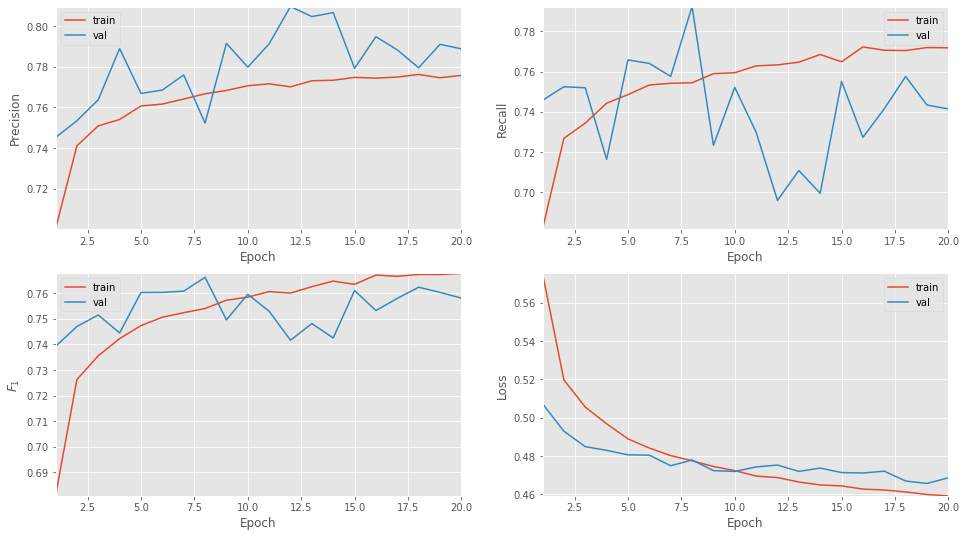

In [71]:
plot_history(history)

#### Check metrics

In [72]:
twitter_model.load_weights(TWITTER_CNN_PATH + 'cnn-frozen-embeddings-08-0.77.hdf5')
predicted = np.round(twitter_model.predict(X_test_seq))
print(classification_report(y_test, predicted, digits = 5))

              precision    recall  f1-score   support

           0    0.77422   0.74330   0.75844     22236
           1    0.75630   0.78610   0.77091     22534

    accuracy                        0.76484     44770
   macro avg    0.76526   0.76470   0.76468     44770
weighted avg    0.76520   0.76484   0.76472     44770



#### Defrost the embedding layer

In [73]:
twitter_model.layers[1].trainable = True
twitter_model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.Adam(lr = 0.0001),
    metrics=[precision, recall, f1, 'accuracy']
)
twitter_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 26)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 26, 200)      20000000    input_2[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 26, 200)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_41 (Conv1D)              (None, 25, 1)        401         dropout_3[0][0]                  
____________________________________________________________________________________________

In [74]:
checkpoint = ModelCheckpoint(
    TWITTER_CNN_PATH + 'cnn-trainable-{epoch:02d}-{val_f1:.2f}.hdf5',
    monitor = 'val_f1',
    save_best_only = True,
    mode = 'max',
    period = 1
)

history_trainable = twitter_model.fit(
    X_train_seq,
    y_train,
    batch_size = 32,
    epochs = 10,
    validation_split = 0.25,
    callbacks = [checkpoint]
)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 134307 samples, validate on 44769 samples
Epoch 1/10
134307/134307 [==============================] - 910s 7ms/step - loss: 0.4654 - precision: 0.7728 - recall: 0.7644 - f1: 0.7627 - accuracy: 0.7705 - val_loss: 0.4673 - val_precision: 0.7905 - val_recall: 0.7382 - val_f1: 0.7572 - val_accuracy: 0.7717
Epoch 2/10
134307/134307 [==============================] - 959s 7ms/step - loss: 0.4554 - precision: 0.7804 - recall: 0.7687 - f1: 0.7686 - accuracy: 0.7762 - val_loss: 0.4643 - val_precision: 0.7888 - val_recall: 0.7464 - val_f1: 0.7611 - val_accuracy: 0.7739
Epoch 3/10
134307/134307 [==============================] - 989s 7ms/step - loss: 0.4484 - precision: 0.7850 - recall: 0.7744 - f1: 0.7740 - accuracy: 0.7818 - val_loss: 0.4617 - val_precision: 0.7916 - val_recall: 0.7453 - val_f1: 0.7616 - val_accuracy: 0.7750
Epoch 4/10
134307/134307 [==============================] - 899s 7ms/step - loss: 0.4406 - precision: 0.7902 - recall: 0.7785 - f1: 0.7788 - accuracy: 0.7867 - val

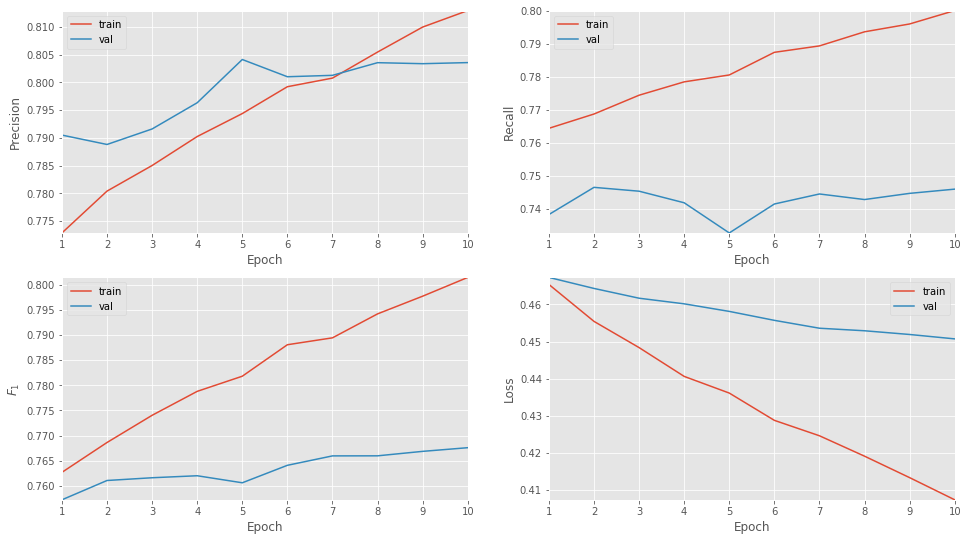

In [75]:
plot_history(history_trainable)

In [76]:
twitter_model.load_weights(TWITTER_CNN_PATH + 'cnn-trainable-10-0.77.hdf5')
predicted = np.round(twitter_model.predict(X_test_seq))
print(classification_report(y_test, predicted, digits = 5))

              precision    recall  f1-score   support

           0    0.75568   0.82025   0.78664     22236
           1    0.80629   0.73831   0.77080     22534

    accuracy                        0.77900     44770
   macro avg    0.78098   0.77928   0.77872     44770
weighted avg    0.78115   0.77900   0.77867     44770



#### Check Save/Load model

In [77]:
twitter_model.save(TWITTER_MODEL)

In [79]:
model = load_model(
    TWITTER_MODEL,
    custom_objects = {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
)
predicted = np.round(model.predict(X_test_seq))
print(classification_report(y_test, predicted, digits = 5))

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


              precision    recall  f1-score   support

           0    0.75568   0.82025   0.78664     22236
           1    0.80629   0.73831   0.77080     22534

    accuracy                        0.77900     44770
   macro avg    0.78098   0.77928   0.77872     44770
weighted avg    0.78115   0.77900   0.77867     44770



## Car review
#### Car Review Constants

In [8]:
# number of auto reviews
REVIEWS_COUNT = 6152
# maximum number of words in auto review
REVIEW_MAX_WORDS_COUNT = 550
# number of words in the dictionary of auto reviews
REVIEWS_DICT_SIZE = 70000

#### Read data
* Reviews with a rating of 2 and below are negative.
* Reviews rated 5 - positive.

In [9]:
reviews_dist_positive = { 'text': [], 'type': [] }
reviews_dist_negative = { 'text': [], 'type': [] }

for i in range(0, REVIEWS_COUNT, 1):
    with open(REVIEWS_PATH + REVIEW_PREFIX + str(i + 1) + REVIEW_SUFFIX) as review:
        review_lines = review.read().splitlines()
        
        # second line of review - rating
        rating = int(review_lines[1])
        
        # third line of review - review text
        text = review_lines[2]
        
        if rating > 4:
            reviews_dist_positive['text'].append(text)
            reviews_dist_positive['type'].append(POSITIVE_MARK)
        elif rating < 3:
            reviews_dist_negative['text'].append(text)
            reviews_dist_negative['type'].append(NEGATIVE_MARK)

reviews_data_positive = pandas.DataFrame(reviews_dist_positive)
reviews_data_negative = pandas.DataFrame(reviews_dist_negative)

#### Print data head

In [10]:
reviews_data_positive.head()

text  type
0  Хочу поделиться эмоциями, которые я испытал вл...     1
1             Долго думали,выбирали,искали машинк...     1
2  Вот уже второй год покоряем Крым с нашим любим...     1
3             В марте 2011 приобрела себе это авт...     1
4  Машина за шесть лет (150000км) эксплуатации ни...     1

In [11]:
reviews_data_negative.head()

text  type
0             Это была моя мечта, я мечтала с окт...    -1
1  Солярис 1,4 МТ хетчбек 1 год 10 месяцев. Торпе...    -1
2             Хочу отписаться об автомобиле Hyund...    -1
3             В ремонте она очень-очень дорогущая...    -1
4  Прошел год с покупки нами этого агрегата.... Я...    -1

#### Data preparation

In [12]:
# balancing samples of positive and negative reviews
reviews_sample_size = min(
    reviews_data_positive.shape[0],
    reviews_data_negative.shape[0]
)
print('Auto Reviews Positive data: ', reviews_data_positive.shape[0])
print('Auto Reviews Negative data: ', reviews_data_negative.shape[0])
print('Auto Reviews Sample data: ', reviews_sample_size * 2)

Auto Reviews Positive data:  3491
Auto Reviews Negative data:  344
Auto Reviews Sample data:  688


In [13]:
reviews_text_raw_data_negative = np.concatenate(
    (reviews_data_negative['text'].values[:reviews_sample_size],
     reviews_data_negative['text'].values[:reviews_sample_size]),
    axis = 0
)

reviews_text_raw_data = np.concatenate(
    (reviews_data_positive['text'].values[:reviews_sample_size * 2], 
     reviews_text_raw_data_negative), 
    axis = 0
)

In [14]:
def preprocess_reviews(review_text):
    review_text = review_text.lower()
    review_text = review_text.replace('ё', 'е')
    review_text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', review_text)
    review_text = re.sub(' +', ' ', review_text)
    return review_text.strip()

In [15]:
reviews_processed_data = [preprocess_reviews(review_text) for review_text in reviews_text_raw_data]
reviews_labels = [1] * reviews_sample_size * 2 + [0] * reviews_sample_size * 2

#### Break the data into training, test and validation
* train 0.6
* test 0.2
* val 0.2

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    reviews_processed_data,
    reviews_labels,
    test_size = 0.2,
    random_state = 1
)

print('train:', len(X_train) * 0.75, 'is', len(X_train) * 0.75 / len(reviews_processed_data))
print('test:', len(X_test), 'is', len(X_test) / len(reviews_processed_data))
print('val:', len(X_train) * 0.25, 'is', len(X_train) * 0.25 / len(reviews_processed_data))

train: 825.0 is 0.5995639534883721
test: 276 is 0.2005813953488372
val: 275.0 is 0.1998546511627907


#### Print all auto reviews in file

In [17]:
with open(DATA_PATH + REVIEW_COMMON_NAME, 'w', encoding='utf-8') as output:
    for i in range(0, REVIEWS_COUNT, 1):
        with open(REVIEWS_PATH + REVIEW_PREFIX + str(i + 1) + REVIEW_SUFFIX) as review_input:
            review = review_input.read().splitlines()[2]
            review = preprocess_reviews(review)
            # Write pre-processed auto reviews to file
            print(review, file = output)

#### Visualization for Auto Reviews

In [17]:
reviews = open(DATA_PATH + REVIEW_COMMON_NAME, encoding='utf-8').read().splitlines()
%matplotlib inline
reviews_preprocessed_data = pandas.Series(reviews).apply(lambda x: len(x.split()))

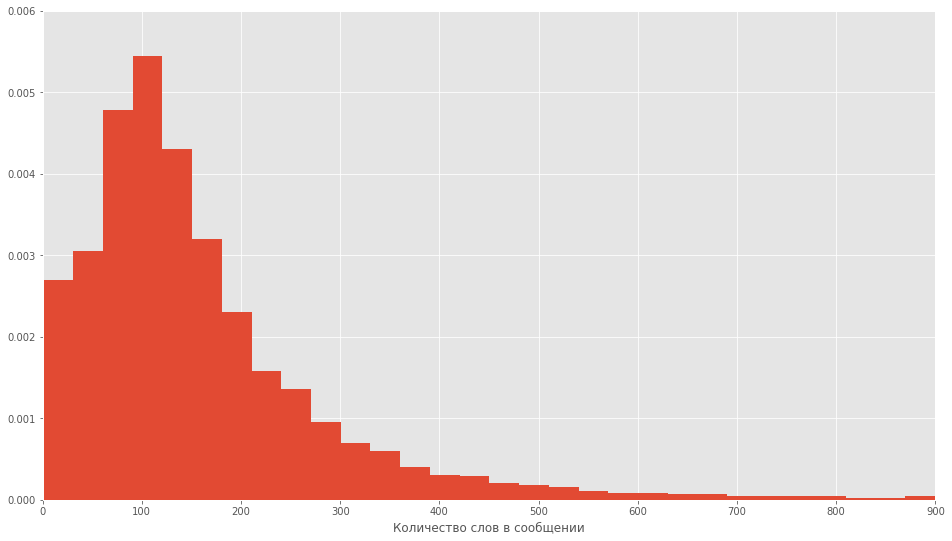

In [18]:
plot_histogram(
    reviews_preprocessed_data.values,
    bins = 120,
    max_x = 900,
    max_y = 0.006
)

In [19]:
for i in range(400, 800, 5):
    reviews_preprocessed_data > i
    percent = (reviews_preprocessed_data > i).sum() / reviews_preprocessed_data.shape[0]
    print("%0.5f for sentence_length=%r" % (1 - percent, i))

0.94197 for sentence_length=400
0.94295 for sentence_length=405
0.94408 for sentence_length=410
0.94636 for sentence_length=415
0.94815 for sentence_length=420
0.94896 for sentence_length=425
0.95107 for sentence_length=430
0.95205 for sentence_length=435
0.95400 for sentence_length=440
0.95530 for sentence_length=445
0.95676 for sentence_length=450
0.95741 for sentence_length=455
0.95888 for sentence_length=460
0.95969 for sentence_length=465
0.96083 for sentence_length=470
0.96180 for sentence_length=475
0.96310 for sentence_length=480
0.96424 for sentence_length=485
0.96538 for sentence_length=490
0.96619 for sentence_length=495
0.96733 for sentence_length=500
0.96814 for sentence_length=505
0.96847 for sentence_length=510
0.96944 for sentence_length=515
0.96977 for sentence_length=520
0.97123 for sentence_length=525
0.97155 for sentence_length=530
0.97237 for sentence_length=535
0.97302 for sentence_length=540
0.97383 for sentence_length=545
0.97448 for sentence_length=550
0.97497 

#### Train Word2Vec model

In [20]:
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', level = logging.INFO)

reviews_data = LineSentence(DATA_PATH + REVIEW_COMMON_NAME)

reviews_model = Word2Vec(
    reviews_data,
    size = 200,
    window = 4,
    min_count = 2,
    workers = multiprocessing.cpu_count()
)

reviews_model.save(MODEL_PATH + REVIEW_MODEL_NAME)

2020-06-10 21:06:51,795 : INFO : collecting all words and their counts
2020-06-10 21:06:51,797 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-06-10 21:06:52,216 : INFO : collected 65619 word types from a corpus of 1007809 raw words and 6152 sentences
2020-06-10 21:06:52,217 : INFO : Loading a fresh vocabulary
2020-06-10 21:06:52,287 : INFO : effective_min_count=2 retains 30798 unique words (46% of original 65619, drops 34821)
2020-06-10 21:06:52,288 : INFO : effective_min_count=2 leaves 972988 word corpus (96% of original 1007809, drops 34821)
2020-06-10 21:06:52,392 : INFO : deleting the raw counts dictionary of 65619 items
2020-06-10 21:06:52,395 : INFO : sample=0.001 downsamples 39 most-common words
2020-06-10 21:06:52,395 : INFO : downsampling leaves estimated 818253 word corpus (84.1% of prior 972988)
2020-06-10 21:06:52,475 : INFO : estimated required memory for 30798 words and 200 dimensions: 64675800 bytes
2020-06-10 21:06:52,477 : INFO : resett

#### Tokenizer

In [21]:
reviews_tokenizer = Tokenizer(num_words = REVIEWS_DICT_SIZE)
reviews_tokenizer.fit_on_texts(X_train)

X_train_seq = reviews_tokenizer.texts_to_sequences(X_train)
X_train_seq = pad_sequences(X_train_seq, maxlen = REVIEW_MAX_WORDS_COUNT)

X_test_seq = reviews_tokenizer.texts_to_sequences(X_test)
X_test_seq = pad_sequences(X_test_seq, maxlen = REVIEW_MAX_WORDS_COUNT)

In [22]:
with open(REVIEWS_TOKENIZER, 'wb') as handle:
    pickle.dump(reviews_tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [23]:
with open(REVIEWS_TOKENIZER, 'rb') as handle:
    reviews_tokenizer = pickle.load(handle)

#### Load Word2Vec model

In [24]:
reviews_w2v_model = Word2Vec.load(MODEL_PATH + REVIEW_MODEL_NAME)
DIM = reviews_w2v_model.vector_size 

# Initialize the matrix embedding layer zeroes
reviews_embedding_matrix = np.zeros((REVIEWS_DICT_SIZE, DIM))

# Add the most frequently occurring words from the training sample in the embedding layer
for word, i in reviews_tokenizer.word_index.items():
    if i >= REVIEWS_DICT_SIZE:
        break
    if word in reviews_w2v_model.wv.vocab.keys():
        reviews_embedding_matrix[i] = reviews_w2v_model.wv[word]

2020-06-10 21:07:31,552 : INFO : loading Word2Vec object from models/reviews_model.w2v
2020-06-10 21:07:32,031 : INFO : loading wv recursively from models/reviews_model.w2v.wv.* with mmap=None
2020-06-10 21:07:32,032 : INFO : setting ignored attribute vectors_norm to None
2020-06-10 21:07:32,032 : INFO : loading vocabulary recursively from models/reviews_model.w2v.vocabulary.* with mmap=None
2020-06-10 21:07:32,033 : INFO : loading trainables recursively from models/reviews_model.w2v.trainables.* with mmap=None
2020-06-10 21:07:32,034 : INFO : setting ignored attribute cum_table to None
2020-06-10 21:07:32,034 : INFO : loaded models/reviews_model.w2v


In [25]:
reviews_input = Input(
    shape = (REVIEW_MAX_WORDS_COUNT,),
    dtype = 'int32'
)

reviews_encoder = Embedding(
    REVIEWS_DICT_SIZE,
    DIM,
    input_length = REVIEW_MAX_WORDS_COUNT,
    weights = [reviews_embedding_matrix],
    trainable = False
)(reviews_input)

In [26]:
branches = []
x = Dropout(0.2)(reviews_encoder)

for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        branch = Conv1D(
            filters = 1,
            kernel_size = size,
            padding = 'valid',
            activation = 'relu'
        )(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)

x = concatenate(branches, axis = 1)
x = Dropout(0.2)(x)
x = Dense(30, activation = 'relu')(x)
x = Dense(1)(x)
output = Activation('sigmoid')(x)

reviews_model = Model(
    inputs = [reviews_input],
    outputs = [output]
)
reviews_model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = [precision, recall, f1, 'accuracy']
)
reviews_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 550)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 550, 200)     14000000    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 550, 200)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 549, 1)       401         dropout_1[0][0]                  
____________________________________________________________________________________________

In [27]:
checkpoint = ModelCheckpoint(
    REVIEWS_CNN_PATH + 'cnn-frozen-embeddings-{epoch:02d}-{val_f1:.2f}.hdf5', 
    monitor = 'val_f1',
    save_best_only = True,
    mode = 'max',
    period = 1
)

history = reviews_model.fit(
    X_train_seq,
    y_train,
    batch_size = 32,
    epochs = 20,
    validation_split = 0.25,
    callbacks = [checkpoint]
)

Train on 825 samples, validate on 275 samples
Epoch 1/20
825/825 [==============================] - 21s 25ms/step - loss: 1.0272 - precision: 0.4948 - recall: 0.5582 - f1: 0.4925 - accuracy: 0.5152 - val_loss: 0.7171 - val_precision: 0.6358 - val_recall: 0.1724 - val_f1: 0.2634 - val_accuracy: 0.5491
Epoch 2/20
825/825 [==============================] - 16s 19ms/step - loss: 0.7606 - precision: 0.5520 - recall: 0.5618 - f1: 0.5355 - accuracy: 0.5467 - val_loss: 0.6892 - val_precision: 0.5648 - val_recall: 0.3048 - val_f1: 0.3917 - val_accuracy: 0.5564
Epoch 3/20
825/825 [==============================] - 17s 21ms/step - loss: 0.7200 - precision: 0.5603 - recall: 0.5970 - f1: 0.5564 - accuracy: 0.5552 - val_loss: 0.6756 - val_precision: 0.6301 - val_recall: 0.2493 - val_f1: 0.3480 - val_accuracy: 0.5600
Epoch 4/20
825/825 [==============================] - 16s 20ms/step - loss: 0.6715 - precision: 0.6236 - recall: 0.6004 - f1: 0.5961 - accuracy: 0.6000 - val_loss: 0.6557 - val_precision

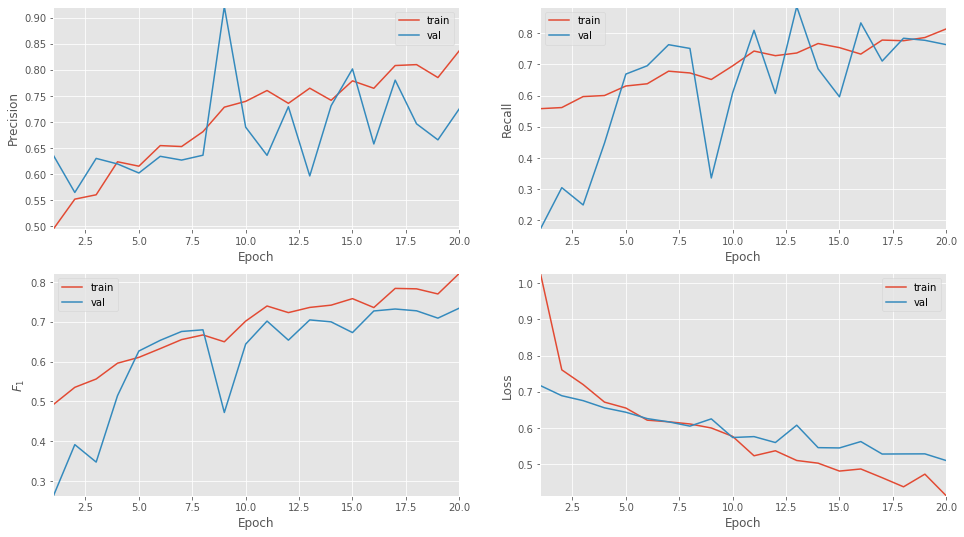

In [28]:
plot_history(history)

In [29]:
reviews_model.load_weights(REVIEWS_CNN_PATH + 'cnn-frozen-embeddings-20-0.73.hdf5')
predicted = np.round(reviews_model.predict(X_test_seq))
print(classification_report(y_test, predicted, digits = 5))

              precision    recall  f1-score   support

           0    0.75912   0.74820   0.75362       139
           1    0.74820   0.75912   0.75362       137

    accuracy                        0.75362       276
   macro avg    0.75366   0.75366   0.75362       276
weighted avg    0.75370   0.75362   0.75362       276



In [30]:
reviews_model.layers[1].trainable = True
reviews_model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.Adam(lr = 0.0001),
    metrics = [precision, recall, f1, 'accuracy']
)
reviews_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 550)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 550, 200)     14000000    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 550, 200)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 549, 1)       401         dropout_1[0][0]                  
____________________________________________________________________________________________

In [31]:
checkpoint = ModelCheckpoint(
    REVIEWS_CNN_PATH + 'cnn-trainable-{epoch:02d}-{val_f1:.2f}.hdf5', 
    monitor = 'val_f1',
    save_best_only = True,
    mode = 'max',
    period = 1
)

history_trainable = reviews_model.fit(
    X_train_seq,
    y_train,
    batch_size = 32,
    epochs = 10,
    validation_split = 0.25,
    callbacks = [checkpoint]
)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 825 samples, validate on 275 samples
Epoch 1/10
825/825 [==============================] - 30s 37ms/step - loss: 0.4038 - precision: 0.8331 - recall: 0.8117 - f1: 0.8183 - accuracy: 0.8279 - val_loss: 0.5060 - val_precision: 0.7482 - val_recall: 0.7370 - val_f1: 0.7324 - val_accuracy: 0.7527
Epoch 2/10
825/825 [==============================] - 26s 31ms/step - loss: 0.3978 - precision: 0.8190 - recall: 0.8300 - f1: 0.8203 - accuracy: 0.8206 - val_loss: 0.5034 - val_precision: 0.7631 - val_recall: 0.7505 - val_f1: 0.7454 - val_accuracy: 0.7673
Epoch 3/10
825/825 [==============================] - 24s 29ms/step - loss: 0.4027 - precision: 0.8285 - recall: 0.8048 - f1: 0.8123 - accuracy: 0.8145 - val_loss: 0.4995 - val_precision: 0.7644 - val_recall: 0.7636 - val_f1: 0.7529 - val_accuracy: 0.7745
Epoch 4/10
825/825 [==============================] - 24s 30ms/step - loss: 0.3896 - precision: 0.8199 - recall: 0.7951 - f1: 0.8020 - accuracy: 0.8085 - val_loss: 0.4965 - val_precision

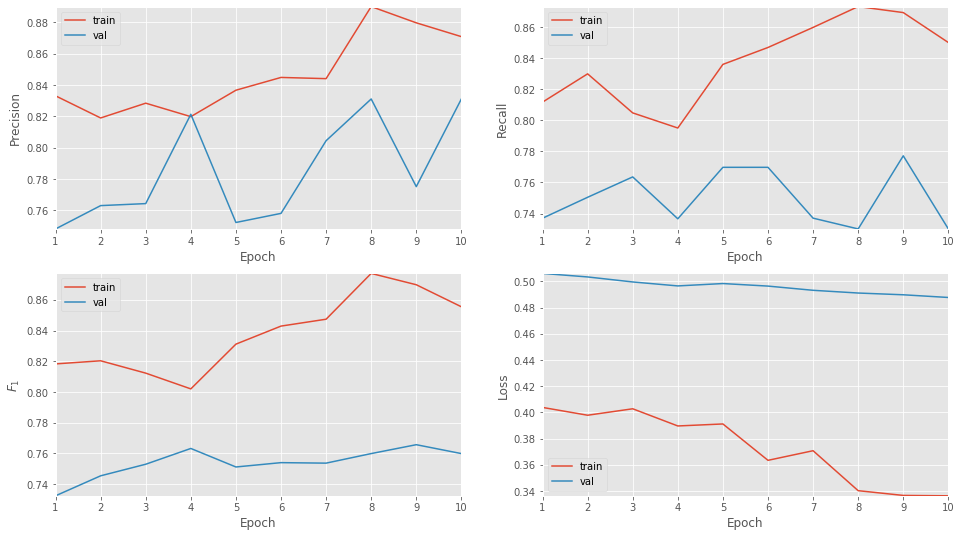

In [32]:
plot_history(history_trainable)

In [33]:
reviews_model.load_weights(REVIEWS_CNN_PATH + 'cnn-trainable-09-0.77.hdf5')
predicted = np.round(reviews_model.predict(X_test_seq))
print(classification_report(y_test, predicted, digits = 5))

              precision    recall  f1-score   support

           0    0.77143   0.77698   0.77419       139
           1    0.77206   0.76642   0.76923       137

    accuracy                        0.77174       276
   macro avg    0.77174   0.77170   0.77171       276
weighted avg    0.77174   0.77174   0.77173       276



#### Check Save/Load model

In [34]:
reviews_model.save(REVIEWS_MODEL)

In [35]:
model = load_model(
    REVIEWS_MODEL,
    custom_objects = {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
)
predicted = np.round(model.predict(X_test_seq))
print(classification_report(y_test, predicted, digits = 5))

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


              precision    recall  f1-score   support

           0    0.77143   0.77698   0.77419       139
           1    0.77206   0.76642   0.76923       137

    accuracy                        0.77174       276
   macro avg    0.77174   0.77170   0.77171       276
weighted avg    0.77174   0.77174   0.77173       276



## Domain Classifier

In [80]:
reviews_data = open(DATA_PATH + REVIEW_COMMON_NAME, encoding = 'utf-8').read().splitlines()

In [81]:
twitter_data_positive = pandas.read_csv(
    DATA_PATH + TWITTER_POSITIVE_NAME,
    sep = ';',
    error_bad_lines = False,
    names = twitter_db_titles,
    usecols = twitter_usecols
)

twitter_data_negative = pandas.read_csv(
    DATA_PATH + TWITTER_NEGATIVE_NAME,
    sep = ';',
    error_bad_lines = False,
    names = twitter_db_titles,
    usecols = twitter_usecols
)

twitter_text_raw_data = np.concatenate(
    (twitter_data_positive['text'].values, 
     twitter_data_negative['text'].values), 
    axis = 0
)

twitter_data = [preprocess_tweets(tweet_text) for tweet_text in twitter_text_raw_data]
np.random.shuffle(twitter_data) # Random number of positive and negative messages for a variety of words

#### Balancing Samples

In [85]:
sample_size = min(
    len(reviews_data),
    len(twitter_data)
)
print('Reviews count:', len(reviews_data))
print('Tweets count:', len(twitter_data))
print('Shape size:', sample_size)

Reviews count: 6152
Tweets count: 226834
Shape size: 6152


In [86]:
processed_data = np.concatenate(
    (twitter_data[:sample_size],
     reviews_data[:sample_size]),
    axis = 0
)
labels_data = [1] * sample_size + [0] * sample_size

#### Break the data into training, test and validation
* train 0.6
* test 0.2
* val 0.2

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    processed_data,
    labels_data,
    test_size = 0.2,
    random_state = 1
)

print('train:', len(X_train) * 0.75, 'is', len(X_train) * 0.75 / len(processed_data))
print('test:', len(X_test), 'is', len(X_test) / len(processed_data))
print('val:', len(X_train) * 0.25, 'is', len(X_train) * 0.25 / len(processed_data))

train: 7382.25 is 0.5999878088426528
test: 2461 is 0.20001625487646293
val: 2460.75 is 0.19999593628088427


In [88]:
print(Counter(y_train))

Counter({0: 4961, 1: 4882})


In [89]:
classifier = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC())
])

In [90]:
print(classifier.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'clf', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'clf__C', 'clf__cache_size', 'clf__class_weight', 'clf__coef0', 'clf__decision_function_shape', 'clf__degree', 'clf__gamma', 'clf__kernel', 'clf__max_iter', 'clf__probability', 'clf__random_state', 'clf__shrinking', 'clf__tol', 'clf__verbose'])


In [91]:
score = 'f1'

tuned_parameters = [
    {'clf__kernel': ['rbf'], 'clf__gamma': [1e-3, 1e-4], 'clf__C': [1, 10, 100, 1000]},
    {'clf__kernel': ['linear'], 'clf__C': [1, 10, 100, 1000]}
]

grid_classifier = GridSearchCV(
    classifier,
    tuned_parameters,
    scoring = '%s_macro' % score
)

grid_classifier.fit(X_train, y_train)

print("Best parameters set found on development set:", grid_classifier.best_params_)
print("Grid scores on development set:")
means = grid_classifier.cv_results_['mean_test_score']
stds = grid_classifier.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_classifier.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set: {'clf__C': 1000, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
Grid scores on development set:
0.343 (+/-0.006) for {'clf__C': 1, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
0.335 (+/-0.000) for {'clf__C': 1, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'}
0.948 (+/-0.012) for {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
0.343 (+/-0.006) for {'clf__C': 10, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'}
0.981 (+/-0.003) for {'clf__C': 100, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
0.948 (+/-0.012) for {'clf__C': 100, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'}
0.990 (+/-0.003) for {'clf__C': 1000, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
0.981 (+/-0.003) for {'clf__C': 1000, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'}
0.989 (+/-0.004) for {'clf__C': 1, 'clf__kernel': 'linear'}
0.989 (+/-0.003) for {'clf__C': 10, 'clf__kernel': 'linear'}
0.989 (+/-0.003) for {'clf__C': 100, 'clf__kernel': 'linear'}
0.989 (+/-0.003) for {'clf__C': 1000, '

In [92]:
predicted = np.round(grid_classifier.predict(X_test))
print(classification_report(y_test, predicted, digits = 5))

              precision    recall  f1-score   support

           0    0.99915   0.98321   0.99111      1191
           1    0.98448   0.99921   0.99179      1270

    accuracy                        0.99147      2461
   macro avg    0.99182   0.99121   0.99145      2461
weighted avg    0.99158   0.99147   0.99146      2461



In [93]:
classifier2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC(C = 1000, gamma = 0.001, kernel = 'rbf'))
])
classifier2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.00

In [94]:
with open(COMMON_MODEL, 'wb') as handle:
    pickle.dump(classifier2, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [95]:
with open(COMMON_MODEL, 'rb') as handle:
    classifier2 = pickle.load(handle)

In [96]:
predicted = np.round(classifier2.predict(X_test))
print(classification_report(y_test, predicted, digits = 5))

              precision    recall  f1-score   support

           0    0.99915   0.98321   0.99111      1191
           1    0.98448   0.99921   0.99179      1270

    accuracy                        0.99147      2461
   macro avg    0.99182   0.99121   0.99145      2461
weighted avg    0.99158   0.99147   0.99146      2461

